In [1]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
ox.config(log_console=True, use_cache=True)
weight_by_length = False

In [2]:
# define the study sites as label : query
places = {'Copenhagen'       : 'Københavns Kommune',
          'Aarhus'        : 'Aarhus Kommune',
          'Odense': 'Odense Kommune',
          'Aalborg': 'Aalborg Kommune',
          'Esbjerg': 'Esbjerg Kommune',
          'Randers': 'Randers Kommune'}

In [3]:
# verify OSMnx geocodes each query to what you expect# verif 
gdf = ox.gdf_from_places(places.values())
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name
0,10.389087,56.330449,55.995712,9.948588,"(POLYGON ((9.948588300000001 56.1444441, 9.950...","Aarhus Kommune, Region Midtjylland, Danmark"
1,10.389381,57.230604,56.811065,9.390561,"(POLYGON ((9.390560799999999 56.9785922, 9.400...","Aalborg Kommune, Region Nordjylland, Danmark"
2,12.734246,55.732703,55.612879,12.453000,"(POLYGON ((12.4530002 55.7122182, 12.4530948 5...","Københavns Kommune, Region Hovedstaden, Danmark"
3,10.576829,55.481989,55.288111,10.175824,"(POLYGON ((10.1758237 55.3605354, 10.1773213 5...","Odense Kommune, Region Syddanmark, Danmark"
4,8.938909,55.596911,55.220686,8.293178,"(POLYGON ((8.2931781 55.5686566, 8.29326050000...","Esbjerg Kommune, Region Syddanmark, Danmark"
5,10.363131,56.701457,56.369887,9.776210,"(POLYGON ((9.7762102 56.4496914, 9.7767541 56....","Randers Kommune, Region Midtjylland, Danmark"


In [4]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [ ]:
bearings = {}
for place in tqdm(sorted(places.keys())):
    
    # get the graph
    query = places[place]
    G = ox.graph_from_place(query, network_type='drive')
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

  0%|                                                    | 0/6 [00:00<?, ?it/s]

# Visualisering

In [60]:

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [85]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color=sns.xkcd_rgb['denim blue']  , edgecolor='k', linewidth=0.5, alpha=0.9)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

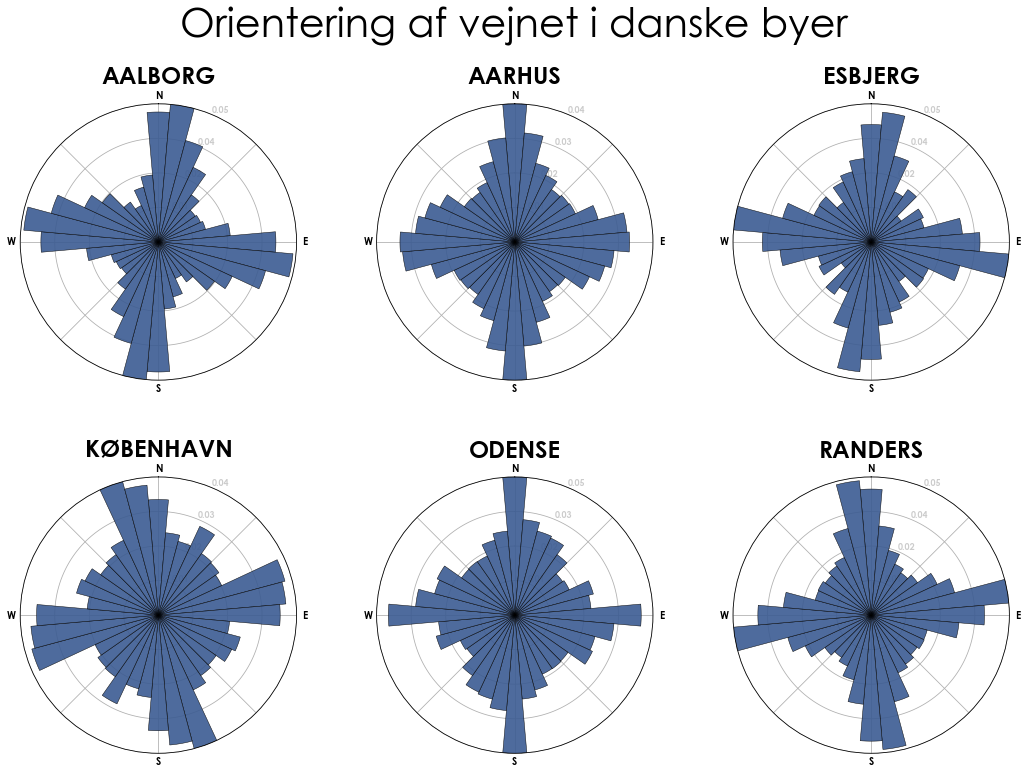

In [86]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':40, 'fontweight':'normal', 'y':1.07}
fig.suptitle('Orientering af vejnet i danske byer', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
plt.show()
plt.close()